Prajna Kandarpa - 20402024
==============================

In [1]:
get_ipython().magic('matplotlib inline')
import pandas;
import matplotlib;
import matplotlib.pyplot as plt
import scipy.io;
import numpy as np
from matplotlib.pylab import rcParams
import math
from scipy import signal
import scipy.stats

from scipy.stats import norm
from scipy.stats import describe
from sklearn.neighbors import KernelDensity

rcParams['figure.figsize'] = 10, 8aa
rcParams['figure.dpi'] = 300;
# rcParams['lines.linewidth'] = 2.2;
plt.style.use('seaborn-poster');

In [3]:
def gaussian(x, mu, var):
    return np.exp(-np.power(x-mu, 2.)/(2*var))

def plot_spike_raster(trial, spikeTimes, ax):
    rep_trials = np.repeat(trial, np.size(spikeTimes))
    sizes = np.ones(len(spikeTimes))*60;
    ax.axhline(y=trial, linewidth=0.3);
    ax.scatter(spikeTimes, np.array([rep_trials]), marker='|', alpha=0.9,
               color='black', s=sizes);

def plot_psth(spikeTimes, num_bins, ax2, **kwargs):
#     counts = ax2.hist(spikeTimes, bins = num_bins, **kwargs);
    hist1, bin1 = np.histogram(spikeTimes, bins=num_bins)
    bincens = 0.5*(bin1[1:] + bin1[:-1])
    width = (bin1[1] - bin1[0]);
    ax2.bar(bincens, hist1, align='center', width=width, alpha=0.8);
    return (hist1, bincens);

## 1a
Load the synthetic data file MT direction tuning. The file contains two
variables: “direction” is a list of stimulus directions for 200 trials.

In [4]:
tuning_data = scipy.io.loadmat('MT direction tuning.mat');

In [5]:
sptimes = 1000*tuning_data['spikeTimes'][0];
directions = tuning_data['direction'];
# print(directions.shape, sptimes.shape)
num_rows = np.array([x.shape[1] for x in sptimes]).sum();
df_cols = ['trial','direction', 'timestamp'];
sp_tr_list = [];
for j in range(0, directions.shape[1]):
    sp_tr = sptimes[j].T;
    direcn = directions[:, j];
    for k in range(0, sp_tr.shape[0]):
        sp = sp_tr[k,:];
        dict1 = {'trial': j+1, 'direction': direcn.tolist()[0], 
                 'timestamp': sp.tolist()[0]};
        sp_tr_list.append(dict1);
df = pandas.DataFrame(sp_tr_list, index=np.arange(0, num_rows), 
                      columns = df_cols);

## 1b 
Plot the spike raster and multi trial firing rate (5ms bins) for 0° trials.
Trial length is 2s.

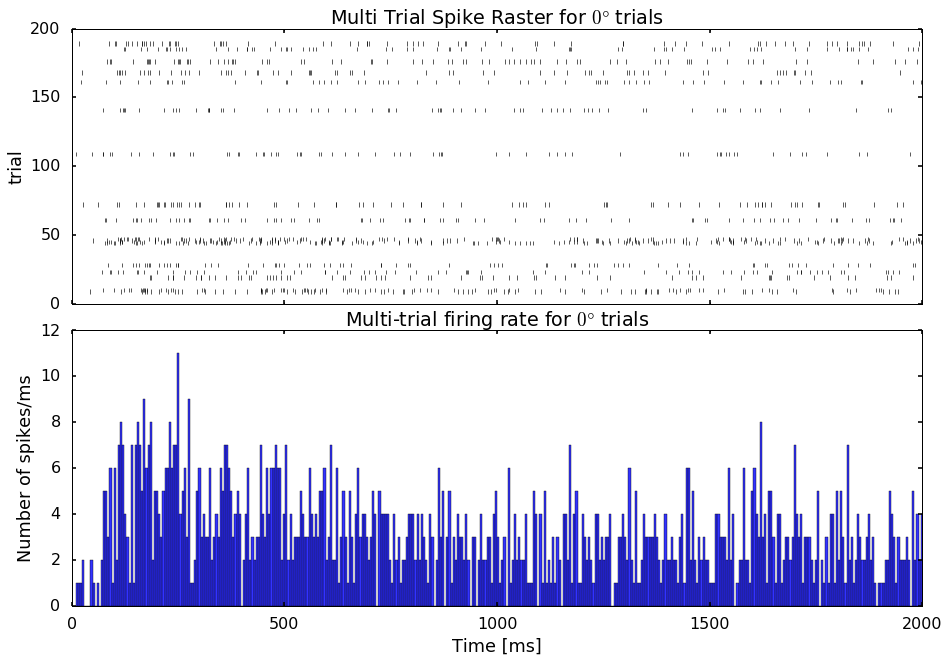

In [6]:
zrdf = df[df.direction==0]; zrdf.shape
f, ax = plt.subplots(2,1, sharex=True)
f.tight_layout();
ax[0].set_xlim([0,2000])
ax[0].set_ylim([0,200])
ax[0].set_title('Multi Trial Spike Raster for $0\degree$ trials')

dt = 5; #5ms sampling
trial_length = 2000; #ms
num_bins = trial_length/dt; #5 ms bins
num_samples = 200; 

t_plot = np.arange(0, 2005, dt);

zrdf.plot.scatter(ax=ax[0], x='timestamp', y='trial', marker='|', alpha=0.8,
                   s=np.ones(len(zrdf))*20, linewidth=.8, color='k');

plot_psth(zrdf['timestamp'].values, num_bins, ax[1], )

ax[1].set_ylabel('Number of spikes/ms');
ax[1].set_title('Multi-trial firing rate for $0\degree$ trials')
ax[1].set_xlabel('Time [ms]');
plt.show()

Use Gaussian window functions to generate single trial rate estimates

## 1c
Plot together the single trial rate estimate for trial 9 using a Gaussian
kernels with SD=5ms and SD=50ms. (Use an appropriate sampling period of your choice for which the rate fluctuations are not visibly distorted in the plot.)

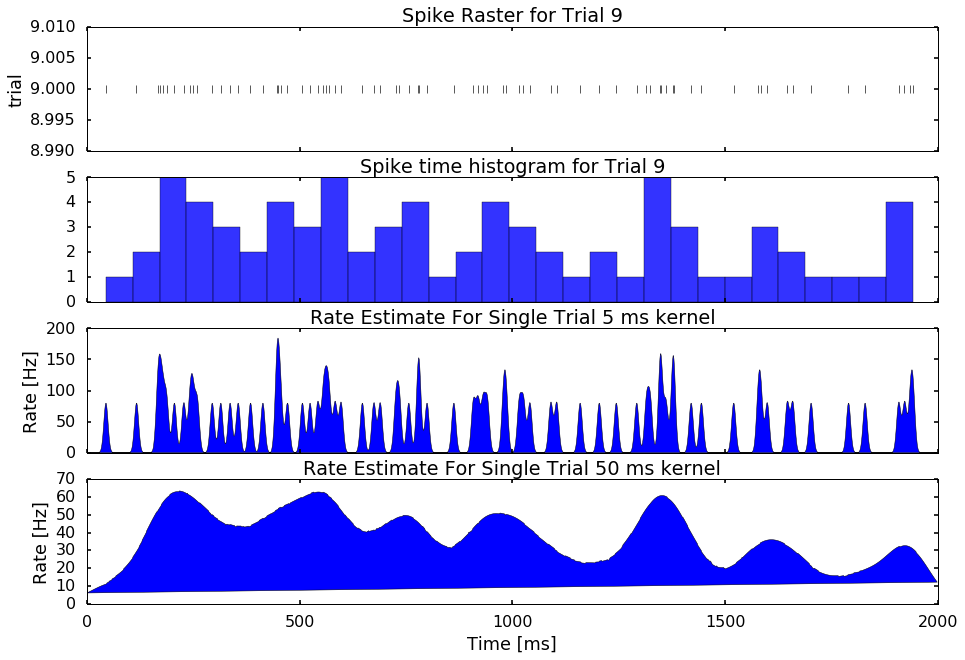

In [7]:
t9_df = df[df.trial == 9];
t9_sptr = np.zeros(2000);
for ts in t9_df.timestamp.tolist():
    t9_sptr[int(ts)] = 1;

num_bins2 = 30
fig1, axx = plt.subplots(4,1, sharex=True)
fig1.tight_layout();
t9_df.plot(kind='scatter', ax=axx[0], x='timestamp', y = 'trial', marker='|', 
           alpha=0.8, s=np.ones(len(t9_df))*60, linewidth=.8, color='k')
# t9_df.timestamp.hist(ax=axx[1], bins = int(num_bins2), histtype='step');
plot_psth(t9_df.timestamp.values, num_bins2, axx[1]);
axx[0].set_title('Spike Raster for Trial 9')
axx[1].set_title('Spike time histogram for Trial 9');


std_dev1 = 5; 
std_dev2 = 50; # in seconds
len_gauss = 60;

window1 = scipy.signal.gaussian(M=len_gauss/2, std=std_dev1);
window1 /= window1.sum()
smooth1 = np.convolve(t9_sptr, window1, 'same')*1000
axx[2].fill(smooth1)

window2 = scipy.signal.gaussian(M=len_gauss*4, std=std_dev2);
window2 /= window2.sum()
smooth2 = np.convolve(t9_sptr, window2, 'same')*1000
axx[3].fill(smooth2)

axx[2].set_title('Rate Estimate For Single Trial 5 ms kernel');
axx[2].set_ylabel('Rate [Hz]');

axx[3].set_title('Rate Estimate For Single Trial 50 ms kernel');
axx[3].set_xlabel('Time [ms]');
axx[3].set_ylabel('Rate [Hz]');

# fgg, axp = plt.subplots(1,1, figsize=[4,4]);
# axp.plot(window1);
# axp.plot(window2);
# # recompute the ax.dataLim
# axp.relim()
# # update ax.viewLim using the new dataLim
# axp.autoscale_view()
# plt.draw()
# plt.show()

## 1d
Plot the tuning curve with standard deviation error bars using data from 50 250ms. (Tip: use a library function to find unique direction values.

In [8]:
all_directons = list(set(df.direction));
duration = 0.2; #in seconds from 50ms to 250ms
t_dict = [];
tuning_dat = [];       
for tr in set(df.trial):
    tr_df = df[df.trial == tr]; # all timestamps for trial
    tr_df_window = tr_df.query('timestamp >= 50.0 & timestamp <= 250.0'); 
    tr_spike_rate = tr_df_window.shape[0]/duration;
    tr_dict = {'direction': list(set(tr_df.direction))[0], 
               'rate': tr_spike_rate};
    t_dict.append(tr_dict);

t_df = pandas.DataFrame(t_dict, index=np.arange(0, len(t_dict)), 
                        columns = ['direction', 'rate']);
for each_dir in all_directons:
    curr_df = t_df[t_df.direction == each_dir];
    avg_rate = curr_df.rate.mean();
    err_bars = curr_df.rate.std();
    tuning_dat.append({'direction': each_dir, 'rate': avg_rate, 
                       'err': err_bars});
tune_df = pandas.DataFrame(tuning_dat, index=np.arange(0, len(tuning_dat)), 
                           columns =['direction', 'rate', 'err']);
tune_df = tune_df.sort_values(['direction'])

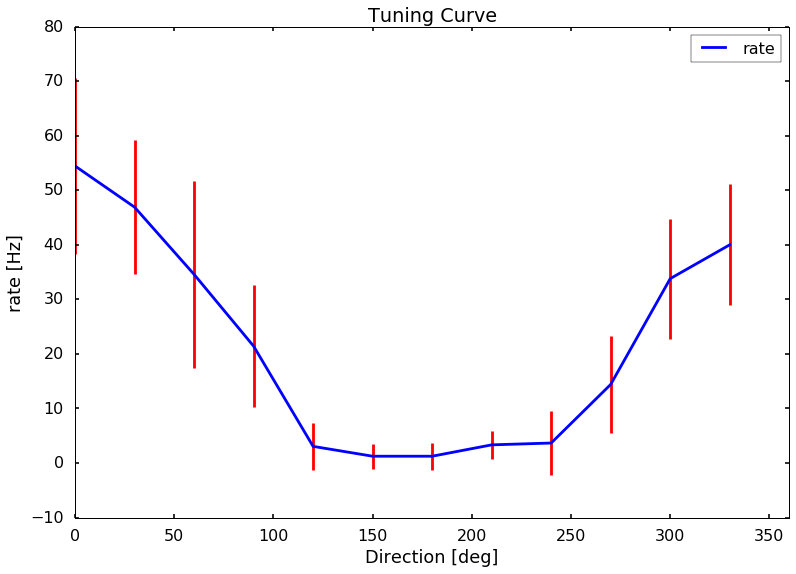

In [9]:
f,ax = plt.subplots();
# ax.plot(tune_df.direction, tune_df.rate)
tune_df.plot.line(ax = ax, x='direction', y='rate', yerr='err', ecolor='r')
ax.set_title('Tuning Curve');
ax.set_xlabel('Direction [deg]')
ax.set_ylabel('rate [Hz]')
ax.set_xlim([0, 360])
plt.show()

## 1e
Search the electrophysiology literature to find a (real) tuning curve from a mouse. Include and explain a figure that shows the tuning curve.
![title](mouse_tuning.png)

The above figure, obtained from <http://www.jneurosci.org/content/28/30/7520.full>, titled Highly Selective Receptive Fields in Mouse Visual Cortex, shows orientation selectivity for primary visual cortex neurons for episodic stimuli of drifting bars at various orientations. The studied neuron exhibited a tendency to select for linearly oriented stimuli, as evident in the spike rasters of sub figure A and in sub figure B, where the tuning curve peaks around 202 degrees and also has another smaller peak for angles closer to 0 degrees


## Spike Triggered Averages
Load the c1p8 data file. This data is from Dayan & Abbott’s web site and
contains H1 neuron spike data collected by de Ruyter van Steveninck. There are two variables: “stim” is stimulus velocity, and “rho” is the response function (Δt=2ms).

In [10]:
cpdat = scipy.io.loadmat('c1p8.mat');
# print(cpdat['stim'].shape)
# print(cpdat['rho'].shape)
# print(describe(cpdat['stim']));
# print(describe(cpdat['rho']));

stim = cpdat['stim'];
resp = cpdat['rho'];
all_sta = [];
timestamp = 0;
for ea in range(0, stim.shape[0]):
    dd = {'stim': stim[ea][0], 'rho': resp[ea][0], 'time': timestamp};
    all_sta.append(dd);
    timestamp += 0.002; #increment by 2ms
    
sta_df = pandas.DataFrame(all_sta, index=np.arange(0, stim.shape[0]), 
                          columns=['stim', 'rho', 'time']);

## 2b. 
Plot the spike triggered average stimulus. You can omit spikes that occur less than a window length after the start of recording.

In [11]:
def plot_STA(stim, resp, time_window, dt, ax):
    trial_length = stim.shape[0];
    n_steps =  int(time_window/dt);
    times = np.arange(0, time_window, dt);
    idx_sptr, _ = np.where(resp[n_steps:trial_length]);
    idx_sptr += n_steps
    all_sptrigs = np.zeros([idx_sptr.shape[0], n_steps]);

    for ea in range(0, idx_sptr.shape[0]):
        all_sptrigs[ea, :] = stim[idx_sptr[ea] - n_steps:idx_sptr[ea]].T;

    ax.plot(times, np.mean(all_sptrigs, axis=0)); ax.set_xlabel('Time[s]');
    ax.set_ylabel('Spike Triggered Average Stimulus Value');
    return;

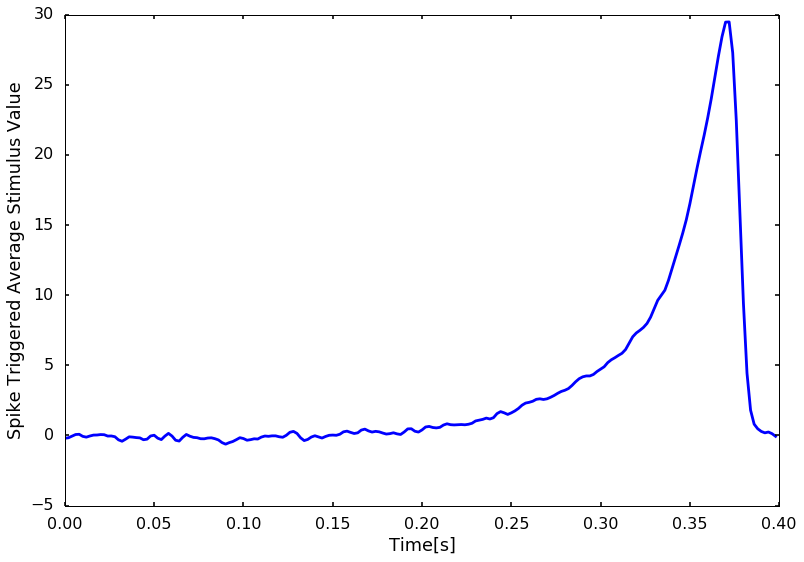

In [12]:
ff, ax = plt.subplots();
plot_STA(stim, resp, time_window=0.4, dt=0.002, ax=ax);

## 2c
Generate 100 seconds of approximate white noise by drawing independent Gaussian distributed samples every ms with mean 0 and SD 1. Save this noise for part (d) below. Use this as input to the function syntheticNeuron function defined below and calculate the spike triggered average from the output.

In [13]:
def synthetic_neuron(drive):
    """
    Simulates a mock neuron with a time step of 1ms.
    Arguments:
    drive - input to the neuron (expect zero mean; SD=1)
    Returns:
    rho - response function (0=non-spike and 1=spike at each time step)
    """
    dt = .001
    T = dt*len(drive)
    time = np.arange(0, T, dt)
    lagSteps = int(.02/dt)
    drive = np.concatenate((np.zeros(lagSteps), drive[lagSteps:])) 
    system = scipy.signal.lti([1], [.03**2, 2*.03, 1])
    _, L, _ = scipy.signal.lsim(system, drive[:,np.newaxis], time) 
    rate = np.divide(30, 1 + np.exp(50*(.05-L)))
    spikeProb = rate*dt
    return np.random.rand(len(spikeProb)) < spikeProb

t_2c = np.linspace(0, 100, 100*1000);
wgn = [np.random.normal(0, 1, 1)[0] for i in t_2c];

## 2d
Create coloured noise by convolving the white noise you generated above with a Gaussian kernel (SD 20ms). Feed this signal into the syntheticNeuron function and calculate the spike triggered average of this signal from the output. How and why is it different?

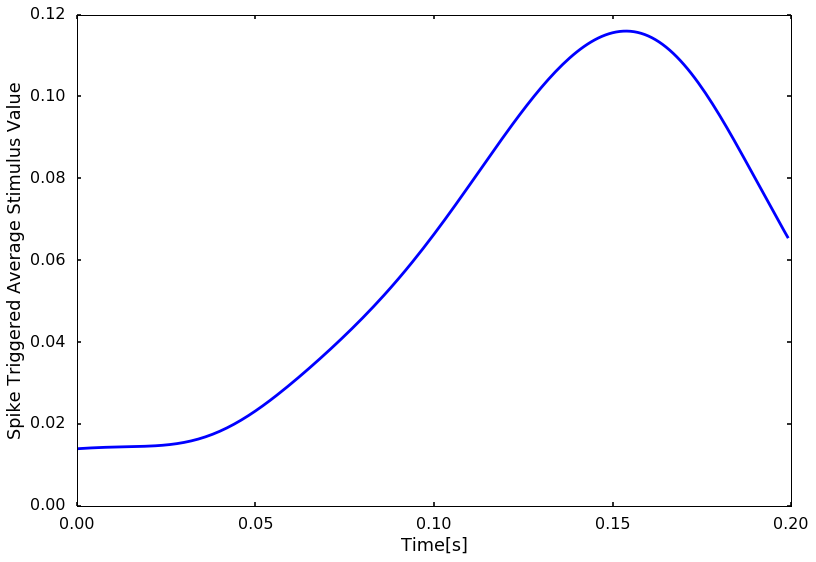

In [17]:
gkernel = scipy.signal.gaussian(M=1000, std=20);
gkernel /= gkernel.sum();
col_wgn = np.convolve(wgn, gkernel, 'same');
spike_train = synthetic_neuron(col_wgn).astype(int);

ff, axpp = plt.subplots();
plot_STA(col_wgn.reshape(-1,1), spike_train.reshape(-1,1), dt=0.001, 
         time_window=0.2, ax=axpp)

The figure above is different from the STA for stimulus generated in Part B because the spike triggered average doesn't fall back completely to normal levels once the stimulus has occured. This hints that the neuron tends to sustain its response after stimulus has appeared and neuron activity has peaked.